# STH co-infection model

In [1]:
using Distributions #Package contaning negative binomial distribution

### Global parameters

In [2]:
const ts = 1/73 #time step in years; 5 days
const halflife = 8.1 #halflife of immunity in hosts in days
const av_age = 18.2 #Initial average age in years in population - used very roughly
const pc_dr = 8/1000 * ts #per capita death rate
const stool_samp = 0.054 #Stool sample used in measuring egg deposition

0.054

### Worm species specific parameters

Defining a data structure with parameter values that are specific to worm species, which will all be of the same type (class)
Can access elements in the structure using '.', e.g `N_a.b`
T means type, e.g. Int, Float64.
The struct is mutable so that parameters can vary if necessary

In [3]:
mutable struct Par{T}
  b                    ::T   # 1.rate of exposure per day - has to be v v low
  Imme_activation      ::T   # 2.to fit - activation of immunity per worm
  Immf_activation      ::T   # 3.as above but for anti fecundity immunity
  WfN                  ::T   # 4.max eggs per day per female worm
  mu_le                ::T   # 5.death rate of early larvae per day
  mu_ll                ::T   # 6.death rate of late larvae per day
  mu_adults            ::T   # 7.death rate of adult worms per day
  M_le                 ::T   # 8.rate of maturation of early larvae per day
  M_ll                 ::T   # 9.rate of maturation of late larvae per day
  pool_egg_loss        ::T   # 10.rate of loss of eggs from field per day
  pool_egg_maturation  ::T   # 11.rate of maturation of eggs in field oer day
  pool_infectives_loss ::T   # 12.rate of loss of infective larvae from field per day
  dens_effect          ::T   # 13.density dependent effect on per worm fecundity
  k                    ::T   # 14.k of negative binomial distribution (mean, k)
  weightings           ::T   # 15.relative weight of worms
  est_modulation       ::T   # 16.modulation of antiestablishment immunity
  fec_modulation       ::T   # 17.modulation of antifecundity immunity
  init_mean            ::T   # 18.mean of initial distribution of worms in pop.
end

Inputting parameters for each species

In [4]:
N_a = Par{Float64}(
    5e-11,
    0.00, 0.00, #1,2,3
    20000 * 365 * ts, 0.067 * 365 * ts, 0.00182 * 365 * ts, #4,5,6
    0.00182 * 365 * ts, 0.07 * 365 * ts, 0.0467 * 365 * ts, #7,8,9
    0.011 * 365 * ts, 0.11 * 365 * ts, 0.15 * 365 * ts, #10,11,12
    0.019, 0.27, 0.037, 0, 0, 16.34) #13,14,15,16,17,18


A_l = Par{Float64}(
    01e-13,
    0.00, 0.00, #1,2,3
    200000 * 365 * ts, 0.067 * 365 * ts, 0.00183 * 365 * ts, #4,5,6
    0.00183 * 365 * ts, 0.10 * 365 * ts, 0.0714 * 365 * ts, #7,8,9
    0.0085 * 365 * ts, 0.0286 * 365 * ts, 0.03 * 365 * ts, #10,11,12
    0.00425, 0.34, 1, 0, 0, 0) #434) #13,14,15,16,17,18

T_t = Par{Float64}(
    01e-14,
    0.00, 0.00, #1,2,3
    20000 * 365 * ts, 1, 0.00182 * 365 * ts, #4,5,6
    0.00182 * 365 * ts, min(0.4 * 365 * ts, 1), 0.0133 * 365 * ts, #7,8,9
    0.00192 * 365 * ts, 0.0286 * 365 * ts, 0.05 * 365 * ts, #10,11,12
    0.001, 0.21, 0.0148, 0, 0, 0)# 38.79) #13,14,15,16,17,18
# Can keep these three Pars structs in an array, accessing as SpPars[1] etc
SpPars = [N_a, A_l, T_t]

3-element Array{##921.Par{Float64},1}:
 ##921.Par{Float64}(5.0e-11, 0.0, 0.0, 100000.0, 0.335, 0.0091, 0.0091, 0.35, 0.2335, 0.055, 0.55, 0.75, 0.019, 0.27, 0.037, 0.0, 0.0, 16.34)
 ##921.Par{Float64}(1.0e-13, 0.0, 0.0, 1.0e6, 0.335, 0.00915, 0.00915, 0.5, 0.357, 0.0425, 0.143, 0.15, 0.00425, 0.34, 1.0, 0.0, 0.0, 0.0)   
 ##921.Par{Float64}(1.0e-14, 0.0, 0.0, 100000.0, 1.0, 0.0091, 0.0091, 1.0, 0.0665, 0.0096, 0.143, 0.25, 0.001, 0.21, 0.0148, 0.0, 0.0, 0.0)  

### Host infections data structures

Each host has infections attributes per species in a data structure:

In [5]:
struct Infection{T}
    Imme    ::T #Anti-establishment immunity strength
    Immf    ::T #Anti-fecundity immunity strength
    PEL     ::T #Pre establishment larvae
    EL      ::T #Established larvae
    AW      ::T #Adult worms
    EOut    ::T #Egg output
end

Define a method so that we can easily make an empty structure.

In [6]:
Infection{T}() where T = Infection{T}(0,0,0,0,0,0)

### Pool attributes data structre

In [7]:
struct Soil{T}
    PIS ::T #Pre-infective stages
    IS  ::T #Infective stages
end

Soil{T}() where T = Soil{T}(0,0)

### Model functions ######

#### Update infections
Arguments are: individual, worm burden, infective stages in pool, halflife, parameters.
We assume everything is happening sequentially rather than simultaneously - therefore:
- Imme and Immf calculation uses WB from the previous time step and are only calculated once
- New eggs uses this time step's adult worms even though Imme and Immf are using *last* timestep's WB.

In [8]:
function update_Infection(i, WB, IS, halflife, p)
    #New infections
    mean = 5 #fixed acquisition
    #mean = p.b * IS #Non fixed acquisition
    if mean > 0
        #exposure = mean
        exposure = float(rand(Poisson(mean)))
        #exposure = float(rand(NegativeBinomial(1, (mean/(mean+p.k)))))
    else
        exposure = 0.0
    end

    #New pre-establishment larvae
    newPEL = ((1-p.mu_le) * i.PEL) + exposure
    PEL = newPEL * (1-p.M_le)
    @assert PEL >= 0 "PEL < 0"

    #Anti establishment immunity
    activation = newPEL * p.Imme_activation
    if p.est_modulation > 0
      modulation = exp(-(p.est_modulation * WB))
    else
      modulation = 1
    end
    Imme = ((0.5^(1/halflife) * i.Imme) + activation) * modulation

    #New established larvae
    newEL = ((1-p.mu_ll) * i.EL) + (p.M_le * newPEL * exp(-Imme))
    EL = newEL * (1-p.M_ll)
    @assert EL >= 0 "EL < 0"

    #Anti fecundity immunity
    activation = newEL * p.Immf_activation
    if p.fec_modulation > 0
      modulation = exp(-(p.fec_modulation * WB))
    else
      modulation = 1
    end
    Immf = ((0.5^(1/halflife) * i.Immf) + activation) * modulation

    #New adults
    AW = ((1-p.mu_adults) * i.AW) + (p.M_ll * newEL)
    @assert AW >= 0 "AW < 0"

    #New eggs
    modulation = exp(-(Immf + (p.dens_effect * AW/2)))
    EOut = AW/2 * p.WfN * modulation

    Infection{Float64}(Imme, Immf, PEL, EL, AW, EOut)
end

update_Infection (generic function with 1 method)

#### Calculate worm burdens (WB)

In [9]:
function update_WBs(pop, pars, n_hosts)
  [sum([x.AW for x in pop[i,:]] .* [p.weightings for p in pars]) for i in 1:n_hosts]
end

update_WBs (generic function with 1 method)

#### Deposit eggs in soil
Arguments: soil, population of infections, parameters

In [10]:
function update_pool(S, pop, p)
    Eggs = sum([x.EOut for x in pop])
    PIS = ((1 - (p.pool_egg_loss + p.pool_egg_maturation)) * S.PIS) + Eggs
    IS = ((1-p.pool_infectives_loss) * S.IS) + (p.pool_egg_maturation * S.PIS)
    Soil{Float64}(PIS, IS)
end

update_pool (generic function with 1 method)

#### Birth and death process

Select all individuals over 80 years old and randomly  select from the rest of
the population - reset ages and infections so population size remains constant

In [11]:
function reset_inds_sys(population, ages, pc_dr)
  for i = 1:length(ages)
    if ages[i] > 80 || rand(Binomial(1, pc_dr)) == 1
      population[i, 1:3] .= Infection{Float64}()
      ages[i] = 0
    end
  end
  return population, ages
end

function update_ages(ages, ts)
    [a += ts for a in ages]
end

update_ages (generic function with 1 method)

### Set up and model run functions

In [12]:
function initworms(init_mean, k)
  if init_mean == 0
    Infection{Float64}()
  else
    Infection{Float64}(0, 0, 0, 0, float(rand(NegativeBinomial(k, (k)/(init_mean + k)))), 0)
  end
end

function SystemSetUp(n_hosts, pars, av_age)
    #Initialise ages, roughly scattered around average age, avoiding negative ages using abs
    ages = [abs(rand(Normal(av_age, av_age))) for i in 1:n_hosts]

    #Initialise pool with eggs and infective stages
    Pool = [Soil{Float64}() for sp in 1:3]

    #Initialise worms with n. binom draw for adults
    pop_infections = [initworms(p.init_mean, p.k) for i in 1:n_hosts, p in pars]

    #Initialise worms burdens based on initial adult burdens
    WBs = update_WBs(pop_infections, pars, n_hosts)
    return ages, Pool, pop_infections, WBs
end


function run_mod(n_hosts, pars, ts, halflife, pop_infections, Pool, ages, WBs, pc_dr)

    #Update ages and remove some individuals
    ages = update_ages(ages, ts)
    pop_infections, ages = reset_inds_sys(pop_infections, ages, pc_dr)

    #Species specific calculations
    for sp in 1:3

        #Per host calculations
        for i in 1:n_hosts
            pop_infections[i, sp] = update_Infection(pop_infections[i, sp], WBs[i],
                                        Pool[sp].IS, halflife, SpPars[sp])
        end

        #Update pool
        Pool[sp] = update_pool(Pool[sp], pop_infections[:, sp], SpPars[sp])
    end

    #Update worm burdens
    WBs = update_WBs(pop_infections, SpPars, n_hosts)

    return ages, pop_infections, Pool, WBs
end

run_mod (generic function with 1 method)

Note on order in run_mod function: WB happens outside of the species and host
loop because it needs information from all species in the whole population

In [13]:
function main(n_runs, n_hosts, pars, av_age, ts, halflife, pc_dr, stool_samp)

  #Set arrays up
  ages, Pool, pop_infections, WBs = SystemSetUp(n_hosts, pars, av_age)

  #For storing summary statistics
  EC = zeros(Float64, n_runs, 3)
  prevs = zeros(Float64, n_runs, 3)
  PEL = zeros(Float64, n_runs, 3)
  EL = zeros(Float64, n_runs, 3)
  adults = zeros(Float64, n_runs, 3)
  EOut = zeros(Float64, n_runs, 3)
  host_monitor = [Infection{Float64}() for i in 1:n_runs, p in pars]

  #Loop through the runs
  for r in 1:n_runs
    ages, pop_infections, Pool, WBs = run_mod(n_hosts, pars, ts, halflife, pop_infections, Pool, ages, WBs, pc_dr)

      #Get means for whole run
      for sp in 1:3

        eggs = [x.EOut for x in pop_infections[:,sp]]
        EC[r,sp] = mean(eggs)/(365 * ts) * stool_samp #scale to match faecal sample size

        prevs[r,sp] = count(i -> i > 0.0, x.AW for x in pop_infections[:,sp])/n_hosts

        PEL[r,sp] = mean([x.PEL for x in pop_infections[:,sp]])
        EL[r,sp] = mean([x.EL for x in pop_infections[:,sp]])
        adults[r,sp] = mean([x.AW for x in pop_infections[:,sp]])
        EOut[r, sp] = mean([x.EOut for x in  pop_infections[:, sp]])
        host_monitor[r,sp] = pop_infections[1,sp]

      end
  end

  #Get final distribution of eggs
  eggs = zeros(Float64, n_hosts, 3)
  for sp in 1:3
    eggs[:,sp] = [(x.EOut/(365*ts)) for x in pop_infections[:,sp]]
  end
  AW = zeros(Float64, n_hosts, 3)
  for sp in 1:3
    AW[:,sp] = [(x.AW/(365*ts)) for x in pop_infections[:,sp]]
  end
  f_PEL = zeros(Float64, n_hosts, 3)
  for sp in 1:3
    f_PEL[:,sp] = [(x.PEL/(365*ts)) for x in pop_infections[:,sp]]
  end
  f_EL = zeros(Float64, n_hosts, 3)
  for sp in 1:3
    f_EL[:,sp] = [(x.EL/(365*ts)) for x in pop_infections[:,sp]]
  end

  return EC, prevs, PEL, EL, adults, EOut, eggs, AW, f_PEL, f_EL
end

main (generic function with 1 method)

## Example run

In [14]:
@time EC, prevs, PEL, EL, adults, EOut, eggs, AW, f_PEL, f_EL = main(1000, 1000, SpPars,
  18.2, ts, halflife, 1/72 * ts, stool_samp)
# ### Plot output
# SO MANY PLOTS. I hope there are enough!
using Plots

  2.762366 seconds (35.01 M allocations: 2.358 GiB, 18.90% gc time)


Means at each time step.
y1 = Na, y2 = Al, y3 = Tt

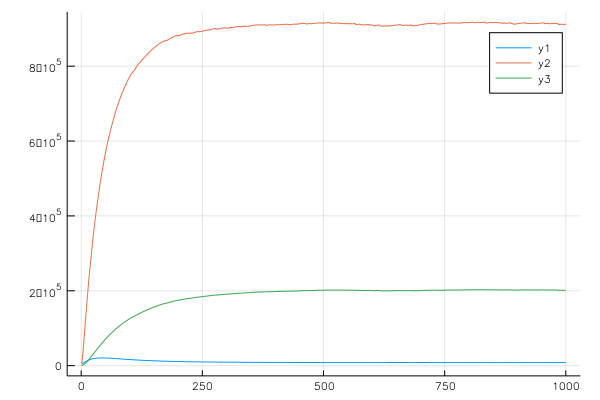

In [15]:
plot(1:1000, PEL[1:1000,:]) #pre-established larvae - as expected
plot(1:1000, EL[1:1000,:]) #established larvae - as expected
plot(1:1000, adults[1:1000,:]) #adult worms
plot(1:1000, EOut[1:1000,:]) #Eggs per host (all eggs per time step)
plot(1:1000, EC[1:1000,:])

Histograms of final/steady
The later in the worm stages these plots get, the more left skewed they get.
I played with the population death rate and found that what happens is that
as individuals age they slowly get up to equilibrium worm burden values.
When an individual is re-set, the worm burdens of the later stages are very far
away from the equilibrium values.
If the pc_dr is LOW and there are few deaths, the left skew is caused by a smaller
number of low values.
If the pc_dr is high and there are lots of deaths, the left skew is removed and
replaced with a right skew as the average age in the population drops and individuals
are more often re-set to zero.
I need therefore to choose the death rate carefully. The death rate in Sri Lanka
around the time the data was collected was 7.007 per 1000 people, and the life
expectancy was 72.0.
This seems to be key in explaining the odd behaviour of the model and maybe it
indicates that age-specific parameters are going to be essential.

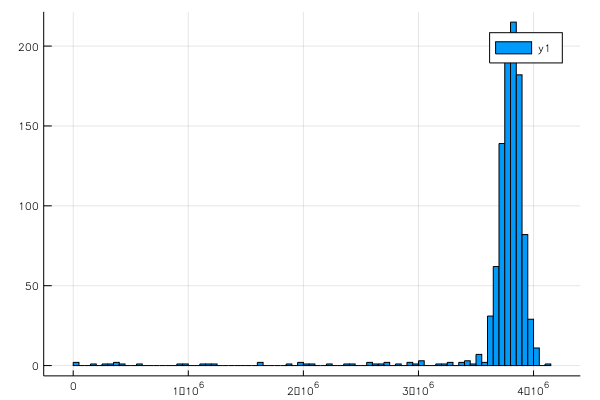

In [16]:
histogram(f_PEL[:,1])
histogram(f_PEL[:,2])
histogram(f_PEL[:,3])

histogram(f_EL[:,1])
histogram(f_EL[:,2])
histogram(f_EL[:,3])

histogram(AW[:,1])
histogram(AW[:,2])
histogram(AW[:,3])

histogram(eggs[:,1])
histogram(eggs[:,2])
histogram(eggs[:,3])

Prevalence is almost always 100% here - because of constant exposure

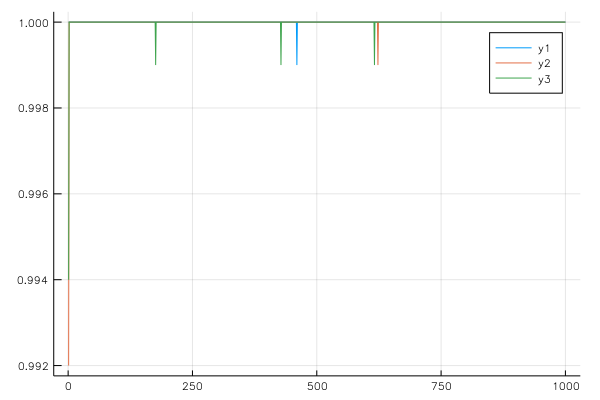

In [17]:
plot(1:1000, prevs[1:1000,:])

### Checks of basic model functions
Solve PEL equation:
PEL = ((1-p.mu_le) * (1-p.M_le) * i.PEL)) + ((1-p.M_le) * exposure)

If at equilibrium, PEL = i.PEL, solution is:

In [18]:
function PEL_sol(M_le, mu_le, exposure)
  (exposure * (1-M_le))/((mu_le * -M_le) + mu_le + M_le)
end

#works!!
Na_PEL_sol = PEL_sol(SpPars[1].M_le, SpPars[1].mu_le, 5)
Al_PEL_sol = PEL_sol(SpPars[2].M_le, SpPars[2].mu_le, 5)
Tt_PEL_sol = PEL_sol(SpPars[3].M_le, SpPars[3].mu_le, 5)

0.0

Tt is always 0; this is planned, the worms do not spend very much
time as pre-establishment larvae

Same steps for adults; equation is:
AW = ((1-p.mu_adults) * i.AW) + (p.M_ll * newEL)

In [19]:
function AW_sol(M_ll, mu_adults, EL)
  newEL = EL/(1-M_ll)
  (M_ll * newEL)/mu_adults
end

#works!!!
Na_AW_sol = AW_sol(SpPars[1].M_ll, SpPars[1].mu_adults, 9.9)
Al_AW_sol = AW_sol(SpPars[2].M_ll, SpPars[2].mu_adults, 6.6)
Tt_AW_sol = AW_sol(SpPars[3].M_ll, SpPars[3].mu_adults, 62.3)

487.7013720077458

Same steps for egg - I think that the density dependence is having an od effect
here.

In [20]:
EOut_sol = function (EL, M_ll, activation, halflife, modulation,
  dens_effect, AW, WfN)
  act = (EL/(1-M_ll)) * activation
  Immf = act/(1-(0.5^1/halflife))
  mod = exp(-Immf + (dens_effect * AW/2)) #females only
  AW/2 * WfN * mod
end

#Not working
Na_EOut_sol = EOut_sol(9.9, SpPars[1].M_ll, SpPars[1].Immf_activation,
                      halflife, 1, SpPars[1].dens_effect, 331, SpPars[1].WfN)
Al_EOut_sol = EOut_sol(6.6, SpPars[2].M_ll, SpPars[2].Immf_activation,
                      halflife, 1, SpPars[2].dens_effect, 400, SpPars[2].WfN)
Tt_EOut_sol = EOut_sol(62.3, SpPars[3].M_ll, SpPars[3].Immf_activation,
                      halflife, 1, SpPars[3].dens_effect, 488, SpPars[3].WfN)

mean(eggs[:,1])
mean(eggs[:,2])
mean(eggs[:,3])

3.7260523921367815e6

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*